In [ ]:
pip install xgboost scikit-learn pandas matplotlib

^C


  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.1-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached numpy-2.3.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp313-cp313-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using c

c:\Users\eitua\OneDrive\Desktop\p1\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Meta-Model Evaluation with Threshold = 0.3 ===
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     55353
           1       0.89      0.88      0.89     33240

    accuracy                           0.92     88593
   macro avg       0.91      0.91      0.91     88593
weighted avg       0.91      0.92      0.91     88593

True Negatives (TN): 51811
False Positives (FP): 3542
False Negatives (FN): 3981
True Positives (TP): 29259


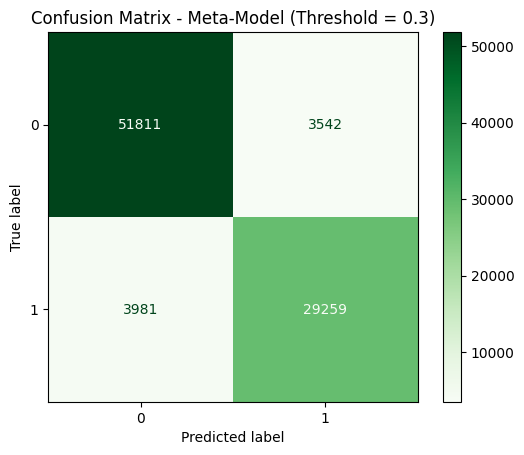

Recall (Sensitivity): 0.880
Precision: 0.892
Accuracy: 0.915


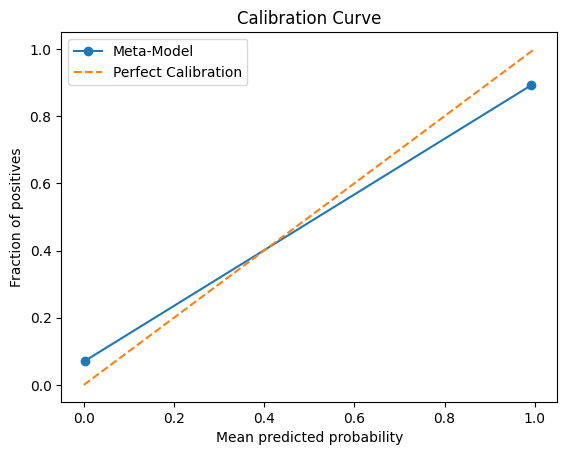

Saved all base models, meta-model, and model info.


In [1]:
import pandas as pd
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from joblib import dump
import json


# Load dataset
dataset = load_dataset("spectrallabs/credit-scoring-training-dataset", split="train")
df = dataset.to_pandas()

# Prepare data
df = df.dropna(subset=['target'])
df = df.dropna()
df['outgoing_incoming_ratio'] = df['outgoing_tx_sum_eth'] / (df['incoming_tx_sum_eth'] + 1e-5)
X = df.drop(columns=['target', 'wallet_address'])
y = df['target'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define thresholds for base models
thresholds = [0.15, 0.3, 0.9]

models = []
meta_features_train = []
meta_features_test = []

base_model_paths = []

for i, t in enumerate(thresholds):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    model = xgb.train(
        {
            'tree_method': 'hist',
            'device': 'cuda',
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.05,
            'subsample': 0.9,
            'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        },
        dtrain,
        num_boost_round=90000
    )

    models.append((model, t))

    # Save base model
    base_model_filename = f"xgb_base_model_{i}_threshold_{t}.json"
    model.save_model(base_model_filename)
    base_model_paths.append(base_model_filename)

    # Generate meta features for stacking
    train_pred = (model.predict(dtrain) > t).astype(int)
    test_pred = (model.predict(dtest) > t).astype(int)
    meta_features_train.append(train_pred)
    meta_features_test.append(test_pred)

# Stack predictions as new feature matrix for meta model
X_meta_train = np.vstack(meta_features_train).T
X_meta_test = np.vstack(meta_features_test).T

# Train meta-model (logistic regression)
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_train)

# Evaluate meta-model
meta_proba = meta_model.predict_proba(X_meta_test)[:, 1]

custom_threshold = 0.3
y_pred_meta = (meta_proba >= custom_threshold).astype(int)

print(f"\n=== Meta-Model Evaluation with Threshold = {custom_threshold} ===")
print(classification_report(y_test, y_pred_meta))

cm = confusion_matrix(y_test, y_pred_meta)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - Meta-Model (Threshold = {custom_threshold})")
plt.show()

recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Accuracy: {accuracy:.3f}")

# Calibration curve plotting
prob_true, prob_pred = calibration_curve(y_test, meta_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Meta-Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.legend()
plt.title("Calibration Curve")
plt.show()

# Save meta-model
with open("loan_scor_meta_model.pkl", "wb") as f:
    pickle.dump(meta_model, f)
dump(meta_model, "loan_scor_meta_model.joblib")

# Save model info including base models and thresholds
model_info = {
    "base_model_paths": base_model_paths,
    "thresholds": thresholds,
    "meta_model_path": "loan_scor_meta_model.pkl"
}

with open("loan_scor_model_info.json", "w") as f:
    json.dump(model_info, f)

print("Saved all base models, meta-model, and model info.")
